

```
# Tiene formato de código
```

Pregunta numero 2


In [66]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [67]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
import json
cocofile= open("/content/drive/MyDrive/IA2/Segunda Instancia/Cartones/polygon/labels_cartones_coco_format.json")
cartones_coco = json.load(cocofile)

In [69]:
cartones_coco['categories'][0],cartones_coco['images'][0], cartones_coco['annotations'][0]

({'id': 1, 'name': 'cartones'},
 {'file_name': 'carton (51).png', 'height': 600, 'id': 1, 'width': 800},
 {'area': 120188.2490525365,
  'bbox': [168.98079763663222,
   108.56720827178731,
   419.4977843426883,
   411.2259970457902],
  'category_id': 1,
  'id': 0,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [[168.98079763663222,
    123.92909896602659,
    212.70310192023635,
    108.56720827178731,
    563.6632200886263,
    140.47267355982277,
    588.4785819793206,
    329.54209748892174,
    255.2437223042836,
    506.794682422452,
    215.0664697193501,
    519.7932053175775]]})

In [70]:
import json
vggfile= open("/content/drive/MyDrive/IA2/Segunda Instancia/Cartones/polygon/labels_cartones_vgg_format.json")
cartones_vgg = json.load(vggfile)

In [71]:
cartones_vgg['carton (51).png']

{'base64_img_data': '',
 'file_attributes': {},
 'filename': 'carton (51).png',
 'fileref': '',
 'regions': {'0': {'region_attributes': {'label': 'cartones'},
   'shape_attributes': {'all_points_x': [168.98079763663222,
     212.70310192023635,
     563.6632200886263,
     588.4785819793206,
     255.2437223042836,
     215.0664697193501,
     168.98079763663222],
    'all_points_y': [123.92909896602659,
     108.56720827178731,
     140.47267355982277,
     329.54209748892174,
     506.794682422452,
     519.7932053175775,
     123.92909896602659],
    'name': 'polygon'}}},
 'size': 400905}

In [72]:
image_id=1
coco_data=COCO("/content/drive/MyDrive/IA2/Segunda Instancia/Cartones/polygon/labels_cartones_coco_format.json")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [73]:
img = coco_data.imgs[image_id]
img

{'file_name': 'carton (51).png', 'height': 600, 'id': 1, 'width': 800}

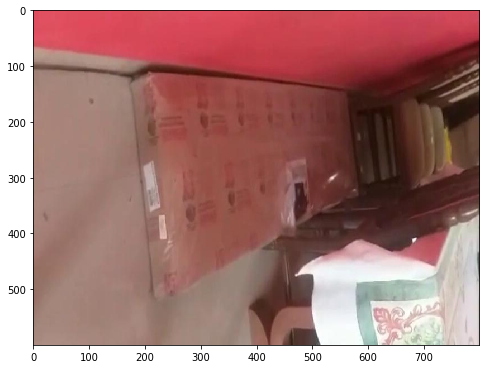

In [74]:
image = np.array(Image.open("/content/drive/MyDrive/IA2/Segunda Instancia/Cartones/cartones/"+img['file_name']).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

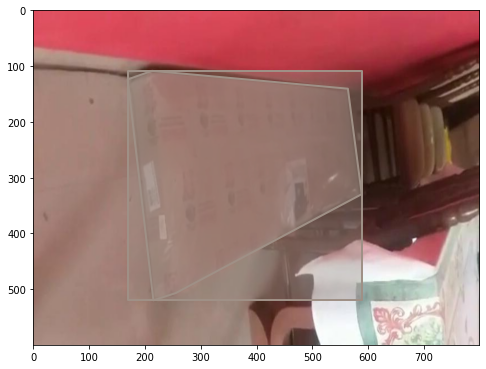

In [75]:
plt.imshow(image)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

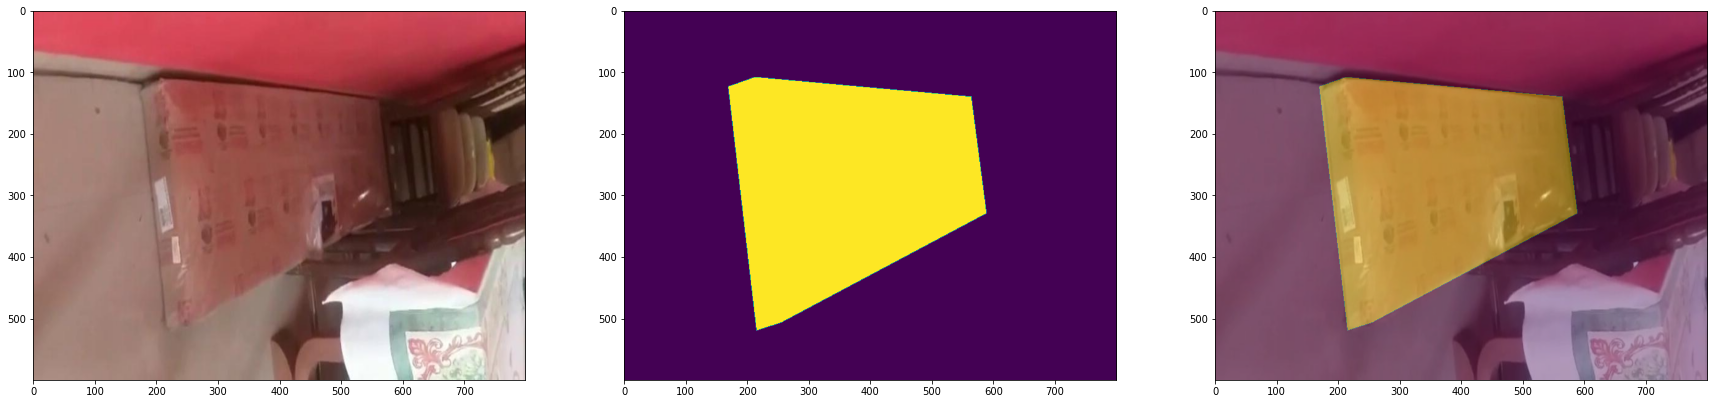

In [76]:
mask = coco_data.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(image)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [77]:
image.shape

(600, 800, 3)

In [78]:
mask = coco_data.annToMask(anns[0])
mask.shape, image.max()

((600, 800), 255)

In [79]:
from random import sample
def loadImages(dataset_coco, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    test_ids = sample([x for x in range(0,len(coco_data.anns))],int(len(coco_data.anns)*split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        img_ = coco_data.imgs[image_id_]
        image_path="/content/drive/MyDrive/IA2/Segunda Instancia/Cartones/cartones/"+img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_)/255
        anns_=dataset_coco.loadAnns(data_[i]['id'])
        mask_ = dataset_coco.annToMask(anns_[0])
        for ian in range(len(anns_)):
            mask_ += dataset_coco.annToMask(anns_[ian])
        if(i not in test_ids):
            img_train_.append(image_path)
            labels_train_.append(mask_)
        else:
            img_test_.append(image_path)
            labels_test_.append(mask_)
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [80]:
img_train, img_test, labels_train, labels_test = loadImages(coco_data, split=0.1)

In [81]:
labels_train.shape, labels_test.shape, labels_test.min(), labels_test.max()

((941, 600, 800), (104, 600, 800), 0, 2)

In [82]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(500,700),
    Resize(600, 800),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.0),
        RGBShift(p=0.3)
    ])
])


In [83]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3,trans=None):
    self.X = X
    self.y = y
    self.n_classes = n_classes
    self.trans = trans

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
      image_load = Image.open(self.X[ix]).convert('RGB')
      if self.trans:
        image_load = trans(image=np.array(image_load))["image"]
      image = np.array(image_load)/255
      img = image.astype(np.float32)

      mask = self.y[ix]    
      img = torch.from_numpy(img).permute(2,0,1)
      mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32)
      return img, torch.from_numpy(mask).permute(2,0,1)

In [84]:
dataset = {
    'train': Dataset(img_train, labels_train, trans=trans),
    'test': Dataset(img_test, labels_test)
}

len(dataset['train']), len(dataset['test'])

(941, 104)

In [85]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 600, 800]), torch.Size([5, 3, 600, 800]))

In [86]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [87]:
model = UNet()
output = model(torch.randn((5,3,600,800)))
output.shape

torch.Size([5, 3, 600, 800])

In [88]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious)

In [89]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [90]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.43157 test_iou 0.78665: 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]



Epoch 1/30 loss 0.48769 iou 0.62123 test_loss 0.43157 test_iou 0.78665


test_loss 0.37891 test_iou 0.79021: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 2/30 loss 0.41167 iou 0.76257 test_loss 0.37891 test_iou 0.79021


test_loss 0.35539 test_iou 0.81063: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 3/30 loss 0.39178 iou 0.76966 test_loss 0.35539 test_iou 0.81063


test_loss 0.31882 test_iou 0.80176: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 4/30 loss 0.38006 iou 0.77620 test_loss 0.31882 test_iou 0.80176


test_loss 0.35314 test_iou 0.79290: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 5/30 loss 0.37984 iou 0.77285 test_loss 0.35314 test_iou 0.79290


test_loss 0.31058 test_iou 0.80423: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]



Epoch 6/30 loss 0.36947 iou 0.78171 test_loss 0.31058 test_iou 0.80423


test_loss 0.33183 test_iou 0.81241: 100%|██████████| 11/11 [00:05<00:00,  1.83it/s]



Epoch 7/30 loss 0.36682 iou 0.78323 test_loss 0.33183 test_iou 0.81241


test_loss 0.37788 test_iou 0.79541: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 8/30 loss 0.36815 iou 0.77792 test_loss 0.37788 test_iou 0.79541


test_loss 0.33794 test_iou 0.81489: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 9/30 loss 0.36313 iou 0.78100 test_loss 0.33794 test_iou 0.81489


test_loss 0.29471 test_iou 0.81421: 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]



Epoch 10/30 loss 0.36281 iou 0.78395 test_loss 0.29471 test_iou 0.81421


test_loss 0.30691 test_iou 0.81200: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 11/30 loss 0.35900 iou 0.78084 test_loss 0.30691 test_iou 0.81200


test_loss 0.34691 test_iou 0.78223: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 12/30 loss 0.35985 iou 0.78201 test_loss 0.34691 test_iou 0.78223


test_loss 0.27666 test_iou 0.82813: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 13/30 loss 0.35431 iou 0.78501 test_loss 0.27666 test_iou 0.82813


test_loss 0.30116 test_iou 0.81656: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 14/30 loss 0.35593 iou 0.78593 test_loss 0.30116 test_iou 0.81656


test_loss 0.29280 test_iou 0.80252: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 15/30 loss 0.35582 iou 0.78360 test_loss 0.29280 test_iou 0.80252


test_loss 0.29938 test_iou 0.81981: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 16/30 loss 0.35665 iou 0.78532 test_loss 0.29938 test_iou 0.81981


test_loss 0.26832 test_iou 0.82731: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 17/30 loss 0.35124 iou 0.78810 test_loss 0.26832 test_iou 0.82731


test_loss 0.30745 test_iou 0.80885: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 18/30 loss 0.34987 iou 0.79141 test_loss 0.30745 test_iou 0.80885


test_loss 0.29613 test_iou 0.82786: 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]



Epoch 19/30 loss 0.35085 iou 0.78831 test_loss 0.29613 test_iou 0.82786


test_loss 0.29000 test_iou 0.82392: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]



Epoch 20/30 loss 0.35306 iou 0.78578 test_loss 0.29000 test_iou 0.82392


test_loss 0.28284 test_iou 0.83478: 100%|██████████| 11/11 [00:05<00:00,  1.83it/s]



Epoch 21/30 loss 0.34810 iou 0.78854 test_loss 0.28284 test_iou 0.83478


test_loss 0.28552 test_iou 0.83000: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]



Epoch 22/30 loss 0.35049 iou 0.78878 test_loss 0.28552 test_iou 0.83000


test_loss 0.28547 test_iou 0.82799: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]



Epoch 23/30 loss 0.35148 iou 0.78874 test_loss 0.28547 test_iou 0.82799


test_loss 0.26026 test_iou 0.82923: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]



Epoch 24/30 loss 0.34635 iou 0.79121 test_loss 0.26026 test_iou 0.82923


test_loss 0.27580 test_iou 0.82515: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]



Epoch 25/30 loss 0.34568 iou 0.79136 test_loss 0.27580 test_iou 0.82515


test_loss 0.30899 test_iou 0.81226: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]



Epoch 26/30 loss 0.34391 iou 0.79062 test_loss 0.30899 test_iou 0.81226


test_loss 0.27367 test_iou 0.82204: 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



Epoch 27/30 loss 0.34284 iou 0.79195 test_loss 0.27367 test_iou 0.82204


test_loss 0.29428 test_iou 0.83173: 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]



Epoch 28/30 loss 0.34299 iou 0.79307 test_loss 0.29428 test_iou 0.83173


test_loss 0.33147 test_iou 0.80091: 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]



Epoch 29/30 loss 0.34361 iou 0.79399 test_loss 0.33147 test_iou 0.80091


test_loss 0.27407 test_iou 0.82601: 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Epoch 30/30 loss 0.33977 iou 0.79417 test_loss 0.27407 test_iou 0.82601


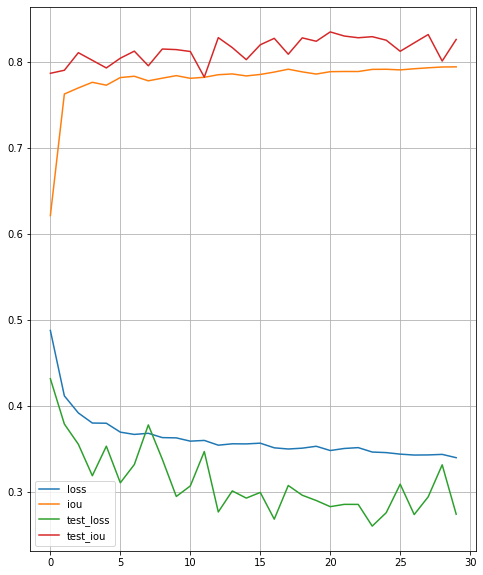

In [91]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [92]:
torch.save(model.state_dict(), 'saved_weights.pt')
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

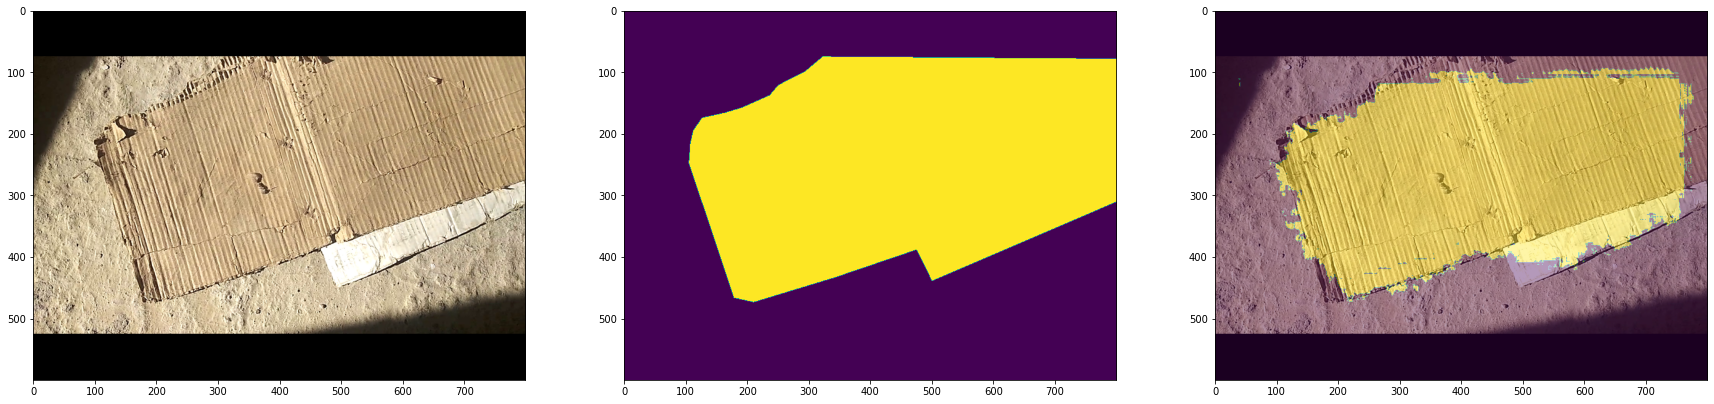

In [93]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))

ax3.imshow(img.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)

plt.show()

In [120]:
image_load_1 = Image.open('/content/drive/MyDrive/IA2/carton1prueba.png').convert('RGB')
image_1 = np.array(image_load_1)/255
img_1 = image_1.astype(np.float32)
img_1 = torch.from_numpy(img_1).permute(2,0,1)

image_load_2 = Image.open('/content/drive/MyDrive/IA2/carton3prueba.png').convert('RGB')
image_2 = np.array(image_load_2)/255
img_2 = image_2.astype(np.float32)
img_2 = torch.from_numpy(img_2).permute(2,0,1)


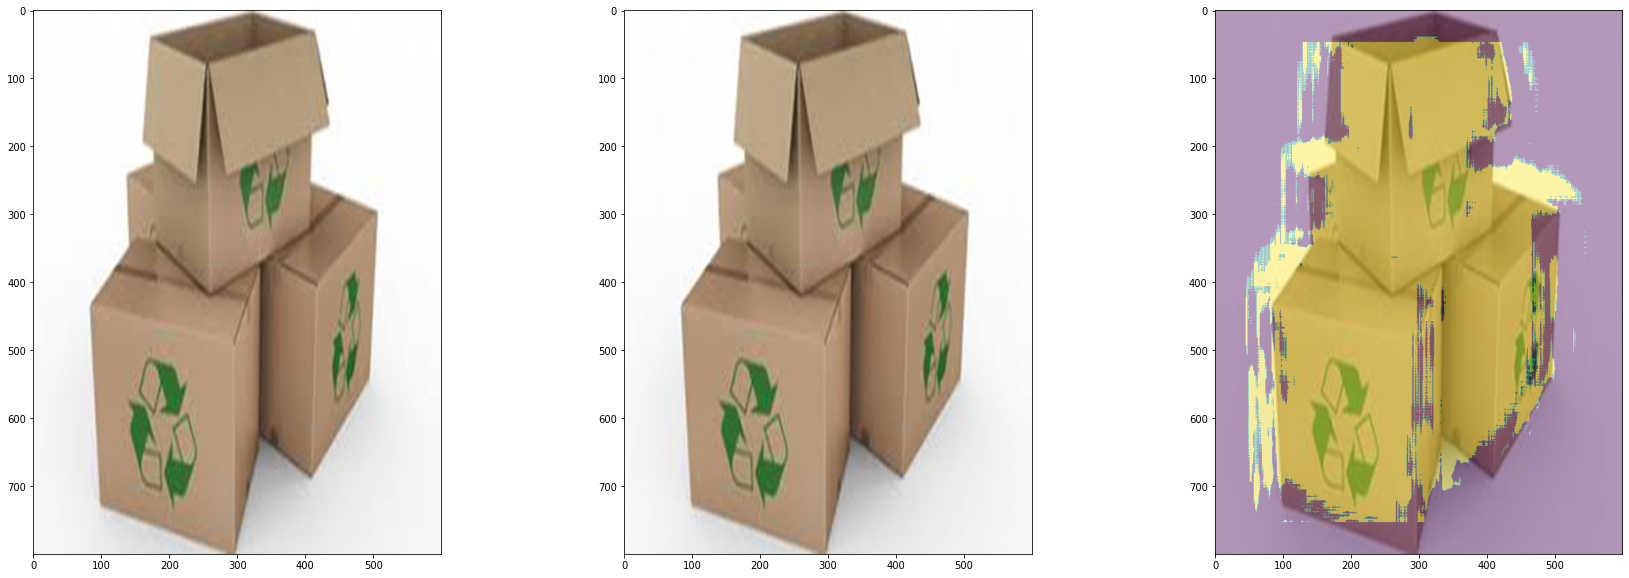

In [121]:
model.eval()
with torch.no_grad():
    output = model(img_2.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img_2.squeeze(0).permute(1,2,0))
ax2.imshow(image_2)

ax3.imshow(img_2.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)


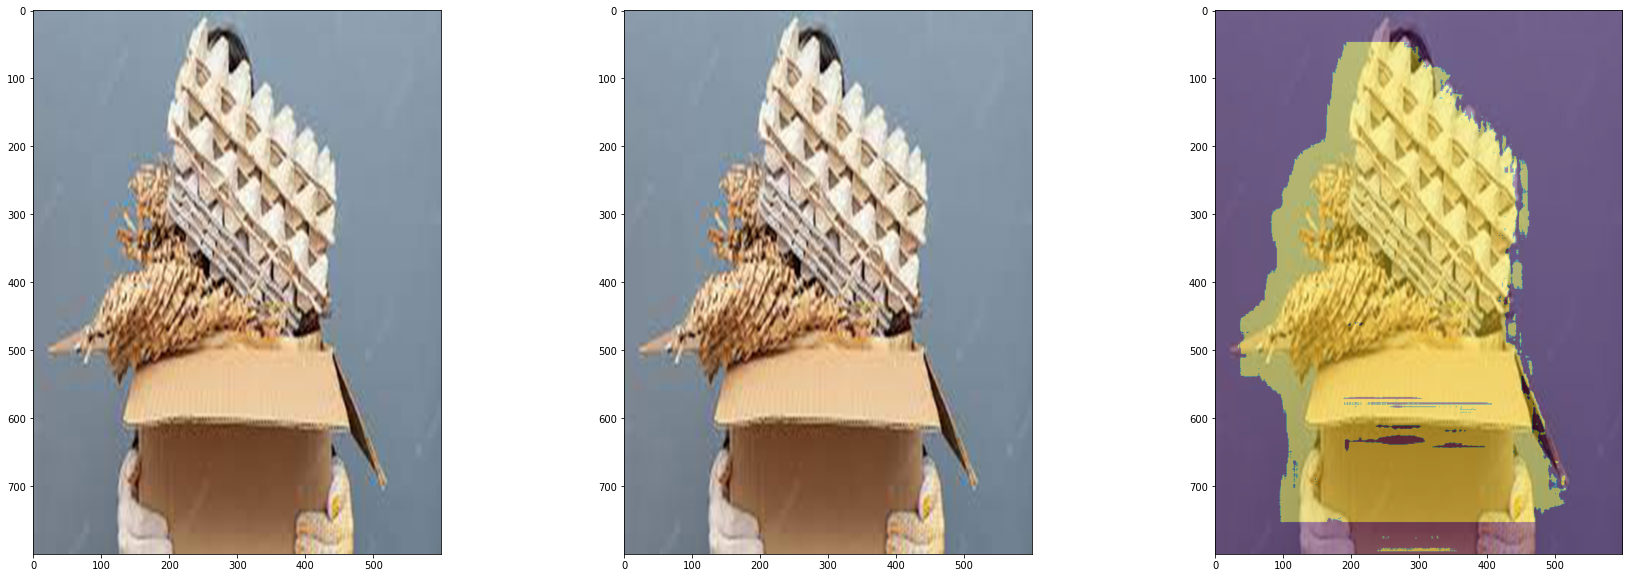

In [116]:
model.eval()
with torch.no_grad():
    output = model(img_1.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img_1.squeeze(0).permute(1,2,0))
ax2.imshow(image_1)

ax3.imshow(img_1.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)